# AI Reliability in Industrial Safety
## A Case Study withABB IRB 1200 and Intel RealSense D415
### Author: Iñigo Aduna Alonso

This project has been developed following the CRISP-DM (Cross Industry Standard Process for Data Mining) structure. In this notebook, we describe the stages of Business Understanding, Data Understanding, and Data Preparation. It covers data gathering and visualization, dataset preparation, splitting into test, validation, and training sets, and applying corruptions to evaluate the model's robustness against different corruptions using ImageNet-C. [https://github.com/hendrycks/robustness.git](https://github.com/hendrycks/robustness.git).


# Import Libraries

In [2]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import shutil
import albumentations as A
import random
from scipy.ndimage import gaussian_filter,convolve,map_coordinates
from PIL import ImageFilter, Image
from skimage import util as sk_util
import skimage.color as sk

# 1.- Data Understanding

This dataset includes several components image segmentation task:

- **Images**: These are the visual representations captured directly by an Intel Realsense camera. 
  
- **Masks**: Accompanying each image, there is a corresponding mask. These masks are essentially binary maps that indicate the location and shape of the specific pieces the robot will have to pick within the images.
  
- **Ground Truth Labels**: These labels provide the location of the masks in the robot frame.

In [11]:
#directory routes
MASKDIR = '../data/masks/*'
IMGDIR = '../data/imgs/*'
LABELSGTDIR ='../data/labels_gt/*.txt'

In [12]:
glob.glob(LABELSGTDIR)

['../data/labels_gt\\image_0.txt',
 '../data/labels_gt\\image_1.txt',
 '../data/labels_gt\\image_10.txt',
 '../data/labels_gt\\image_11.txt',
 '../data/labels_gt\\image_12.txt',
 '../data/labels_gt\\image_13.txt',
 '../data/labels_gt\\image_14.txt',
 '../data/labels_gt\\image_15.txt',
 '../data/labels_gt\\image_16.txt',
 '../data/labels_gt\\image_17.txt',
 '../data/labels_gt\\image_18.txt',
 '../data/labels_gt\\image_19.txt',
 '../data/labels_gt\\image_2.txt',
 '../data/labels_gt\\image_20.txt',
 '../data/labels_gt\\image_21.txt',
 '../data/labels_gt\\image_22.txt',
 '../data/labels_gt\\image_23.txt',
 '../data/labels_gt\\image_3.txt',
 '../data/labels_gt\\image_4.txt',
 '../data/labels_gt\\image_5.txt',
 '../data/labels_gt\\image_6.txt',
 '../data/labels_gt\\image_7.txt',
 '../data/labels_gt\\image_8.txt',
 '../data/labels_gt\\image_9.txt']

In [13]:
mask_files = sorted(glob.glob(MASKDIR), key=lambda x: int(x.split('_')[1].split('.')[0]))
img_files = sorted(glob.glob(IMGDIR), key=lambda x: int(x.split('_')[1].split('.')[0]))
labels_gt_files = sorted(glob.glob(LABELSGTDIR), key=lambda x: int(x.split('image_')[1].split('.txt')[0]))


## 1.1 Visualization of Dataset Components

This code snippet checks that there are images, masks and label files available before proceeding, loads and displays them:

- **Mask Image**: Loaded in grayscale to show the segmentation mask.
- **Original Image**: Loaded in color and converted from BGR (OpenCV's default) to RGB for accurate color representation in Matplotlib.
- **Label Text**: Displays the ground truth label text in the robot frame.


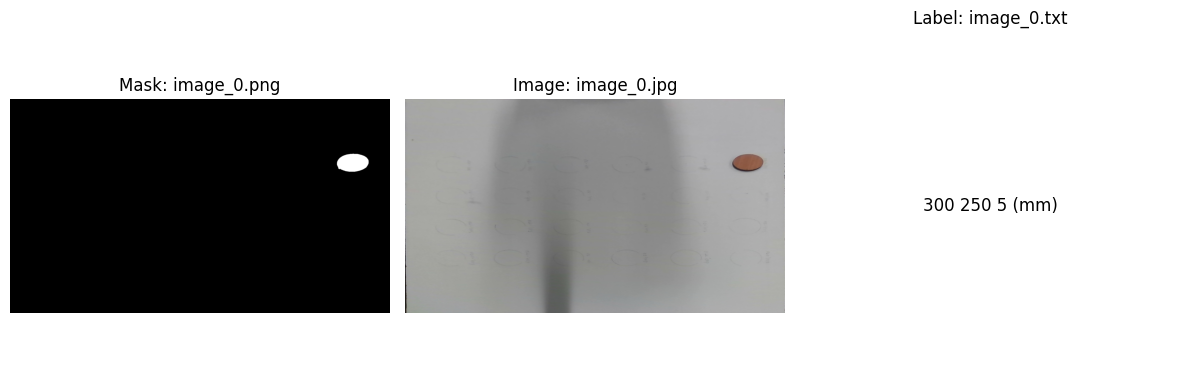

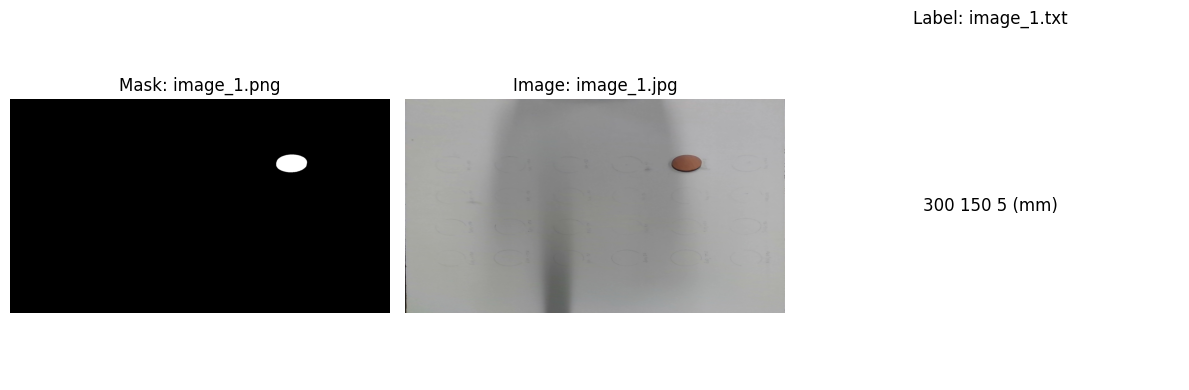

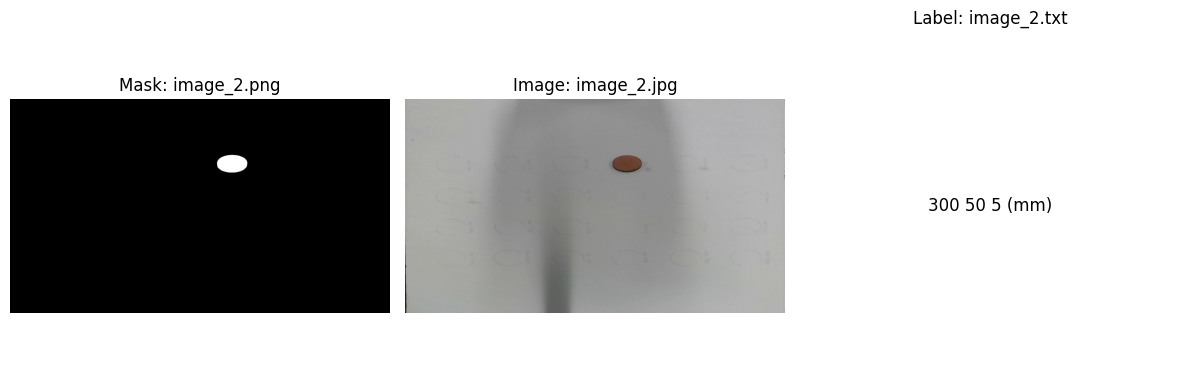

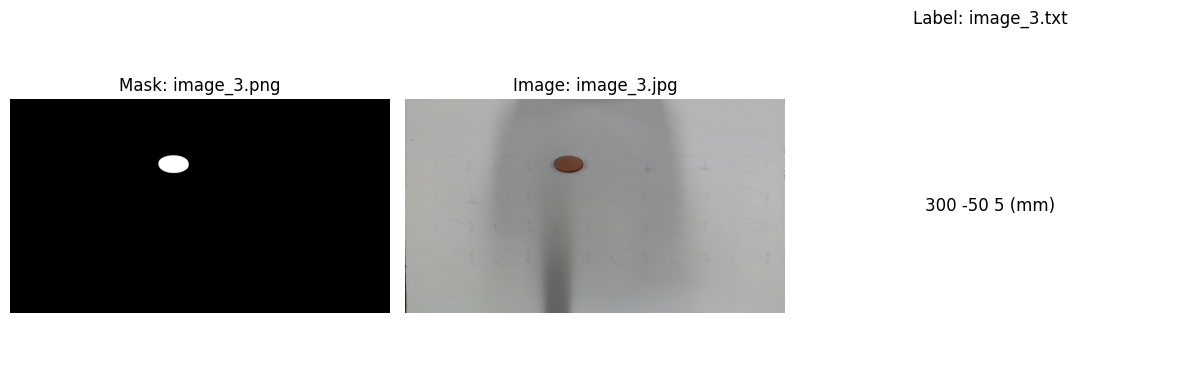

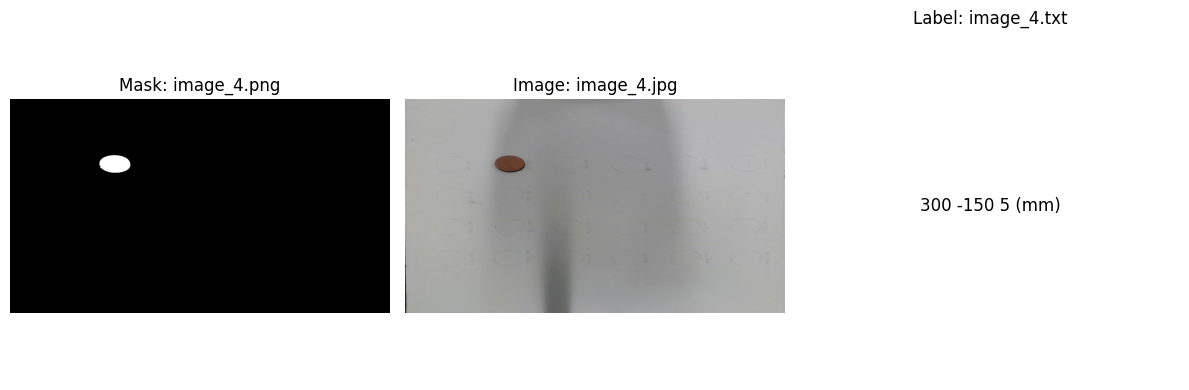

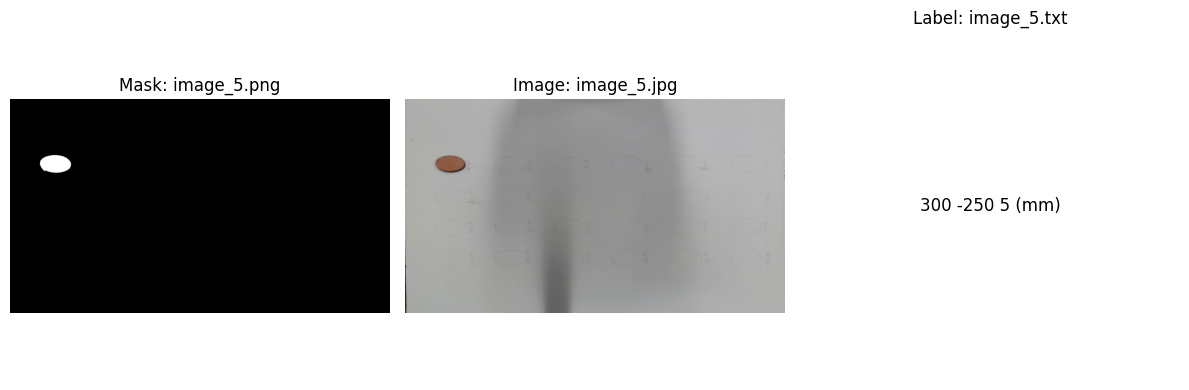

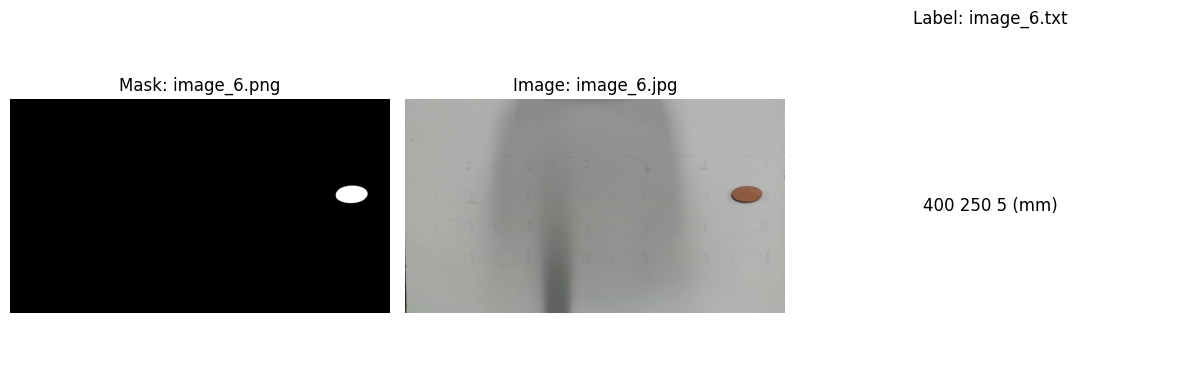

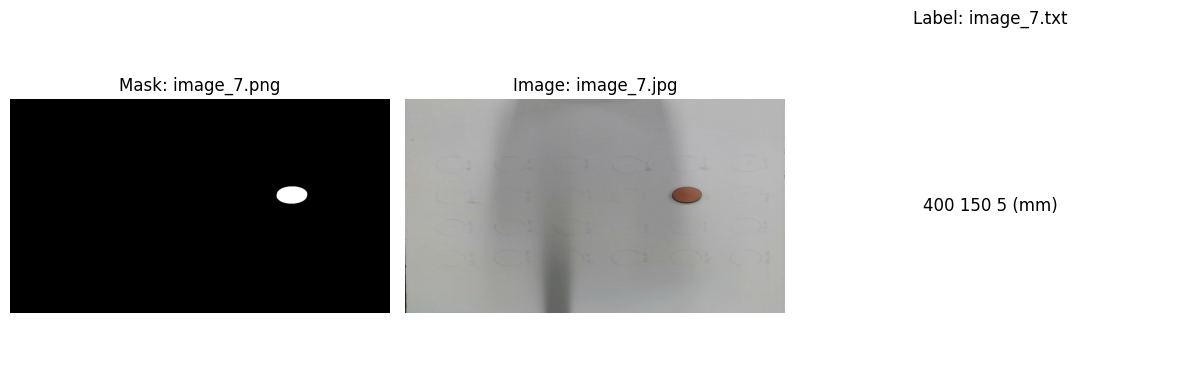

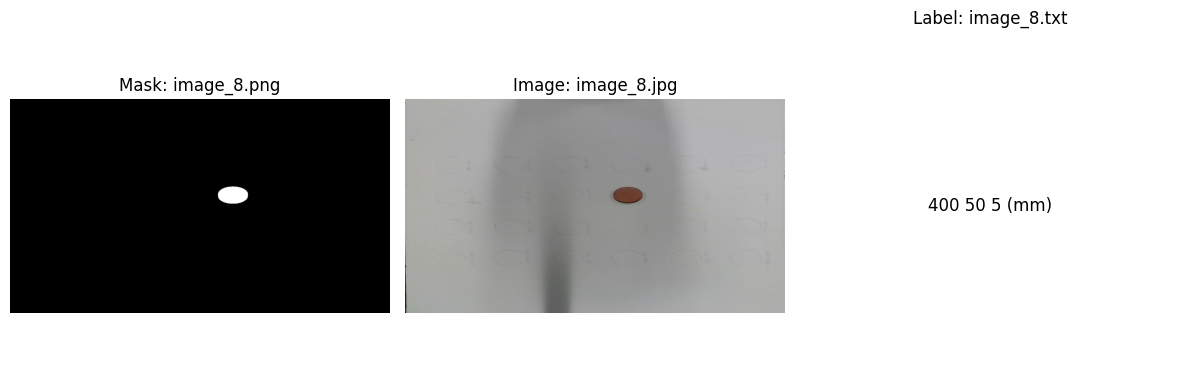

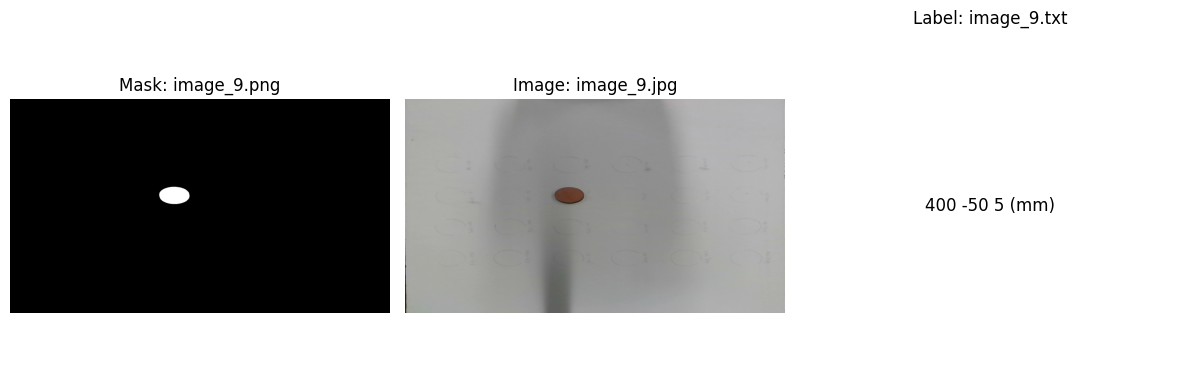

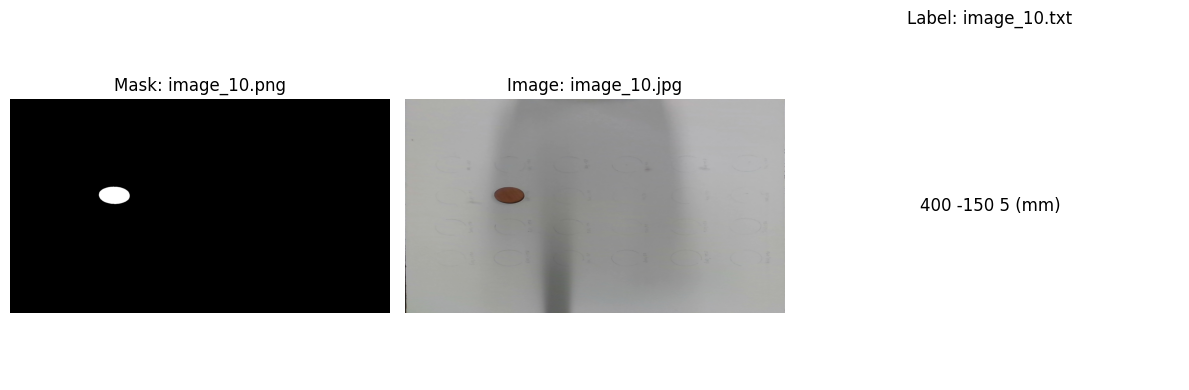

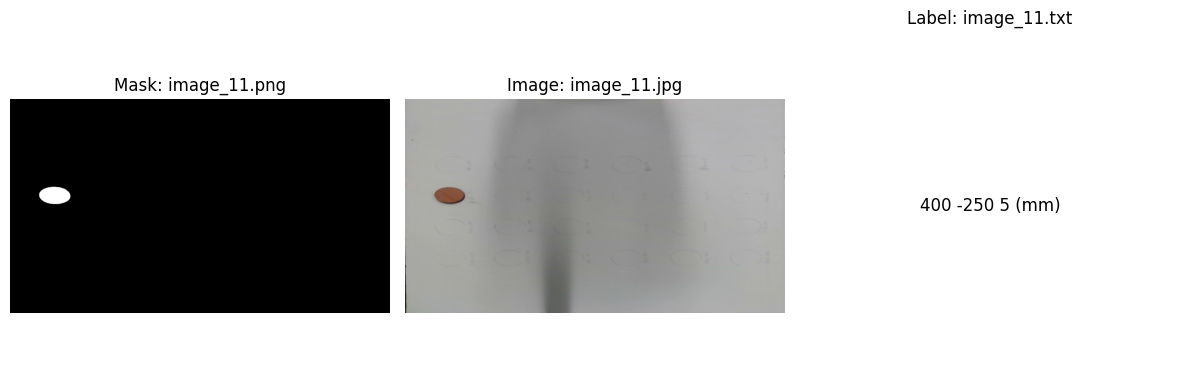

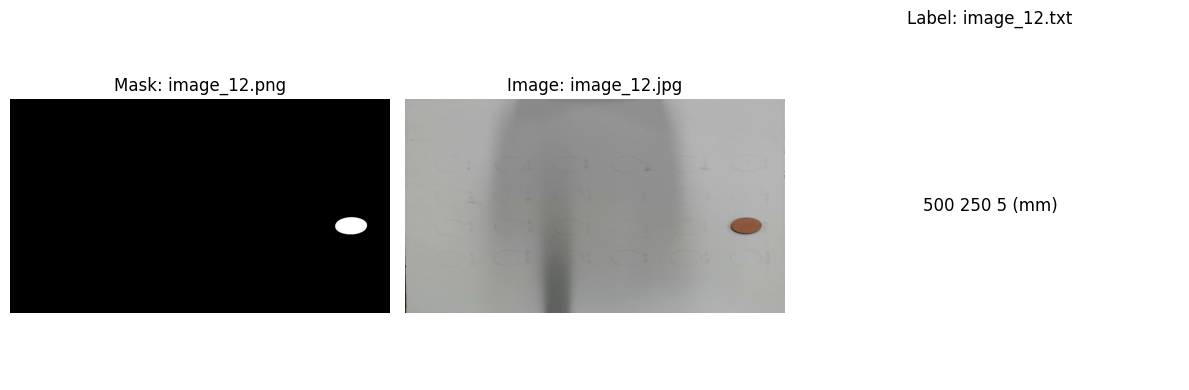

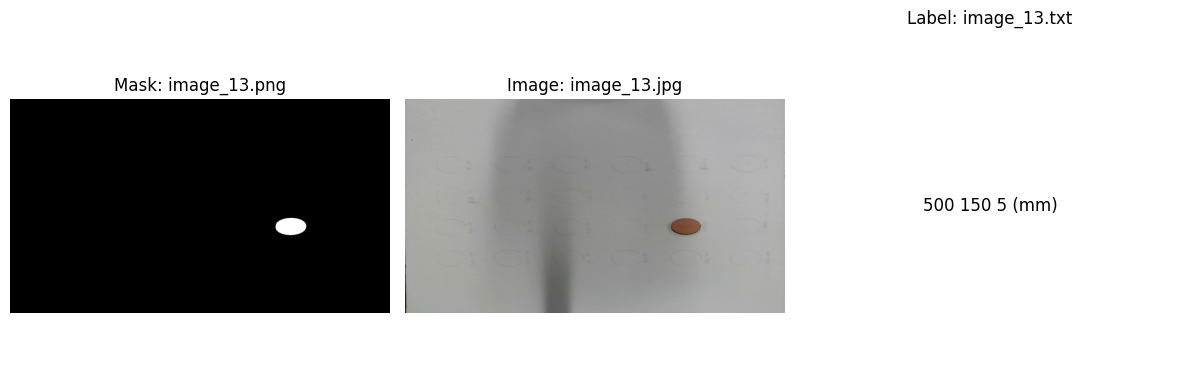

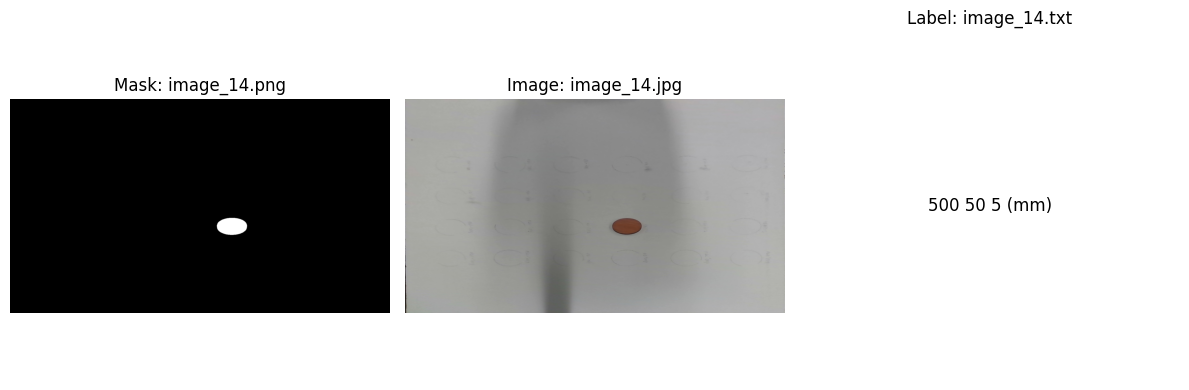

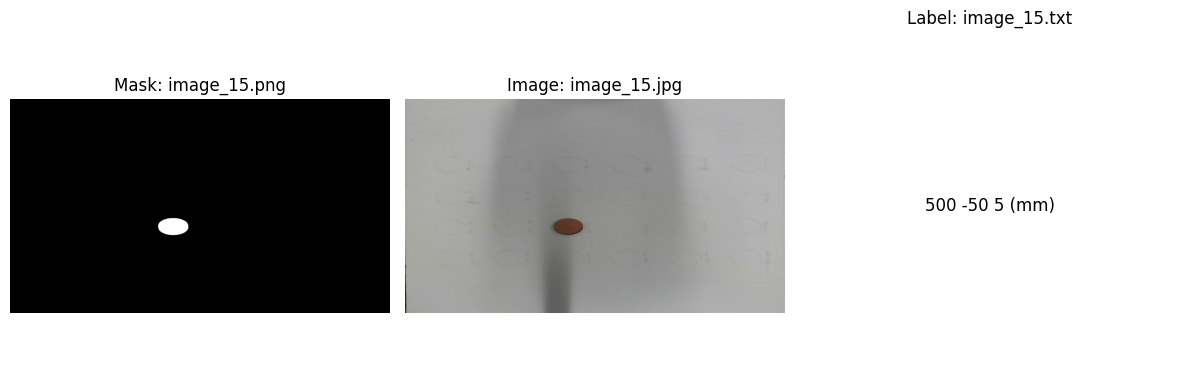

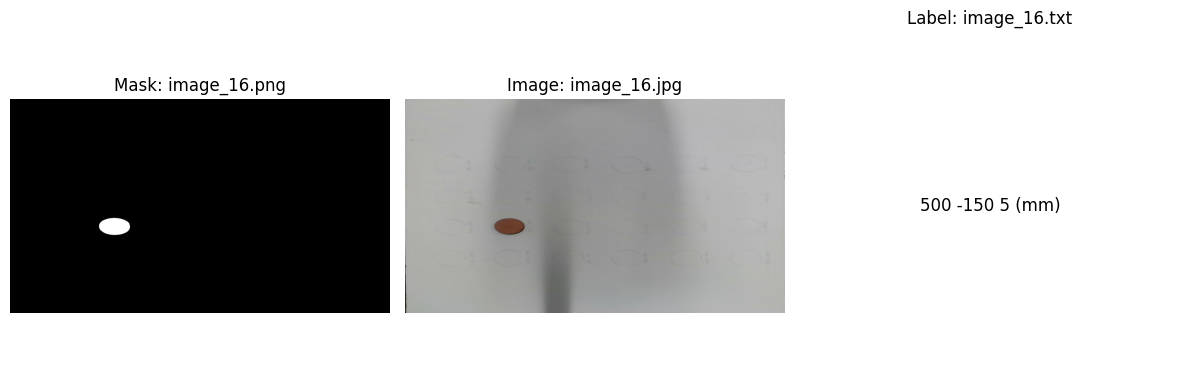

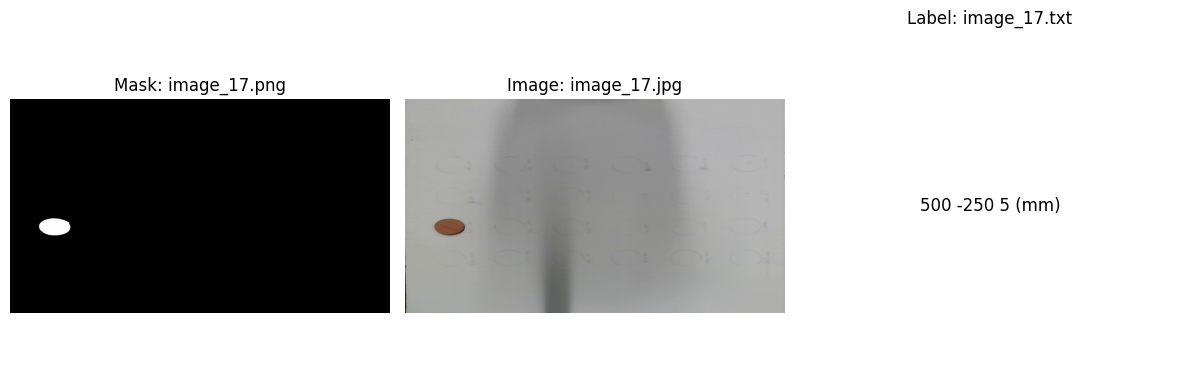

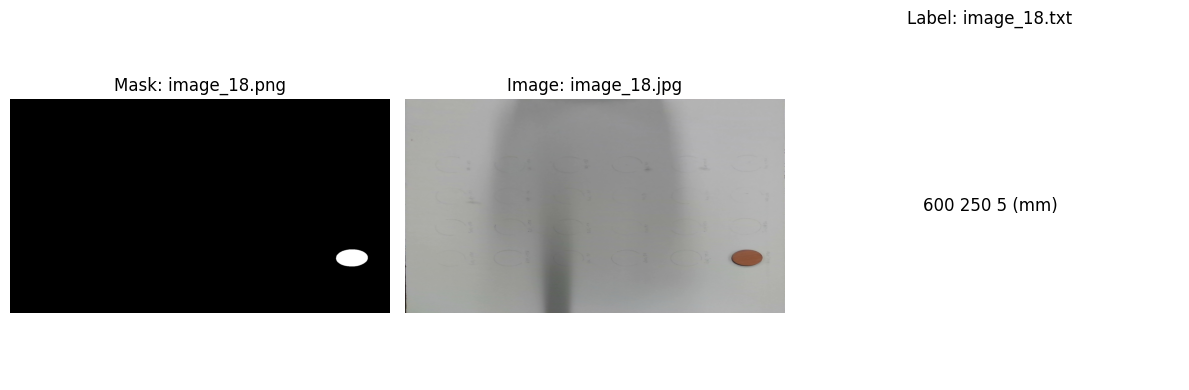

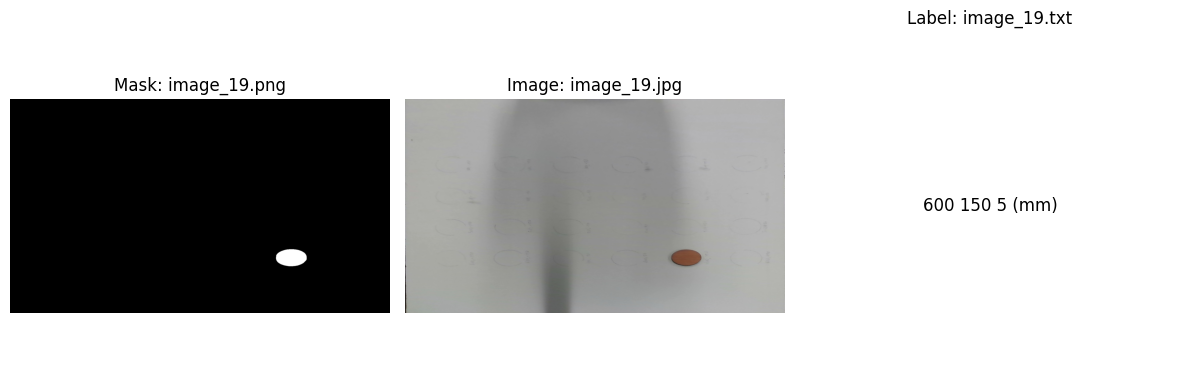

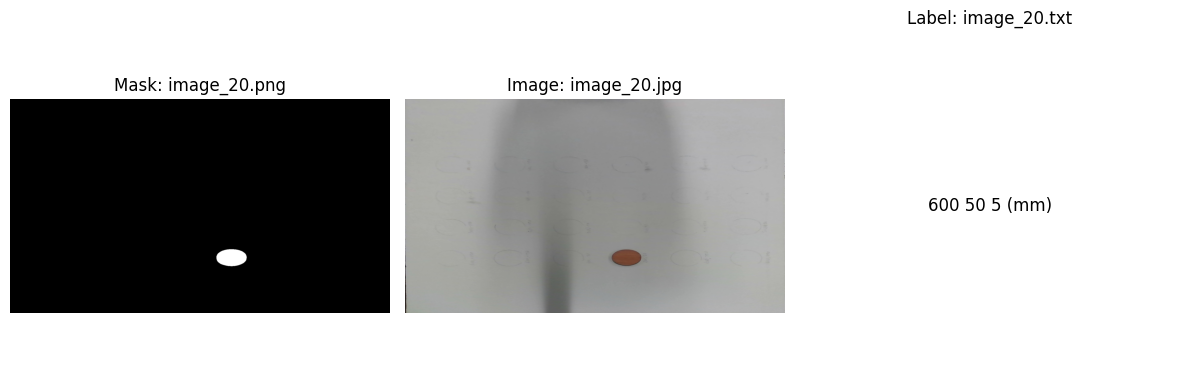

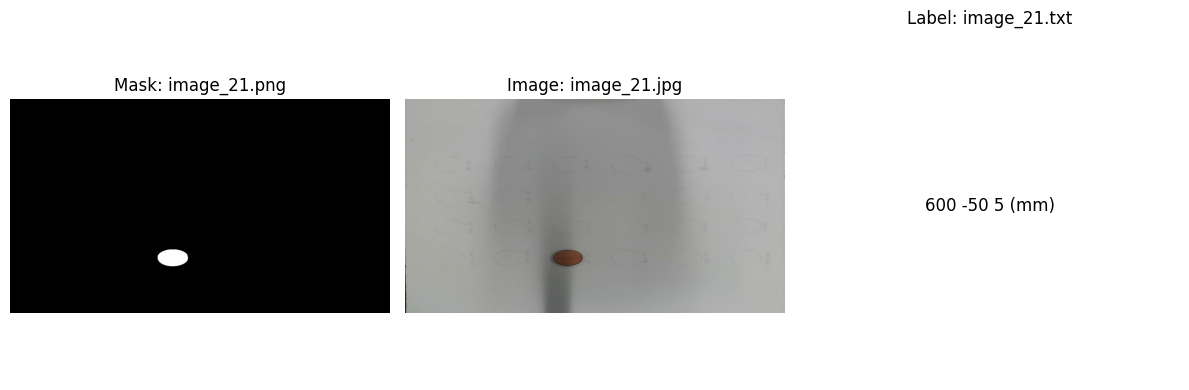

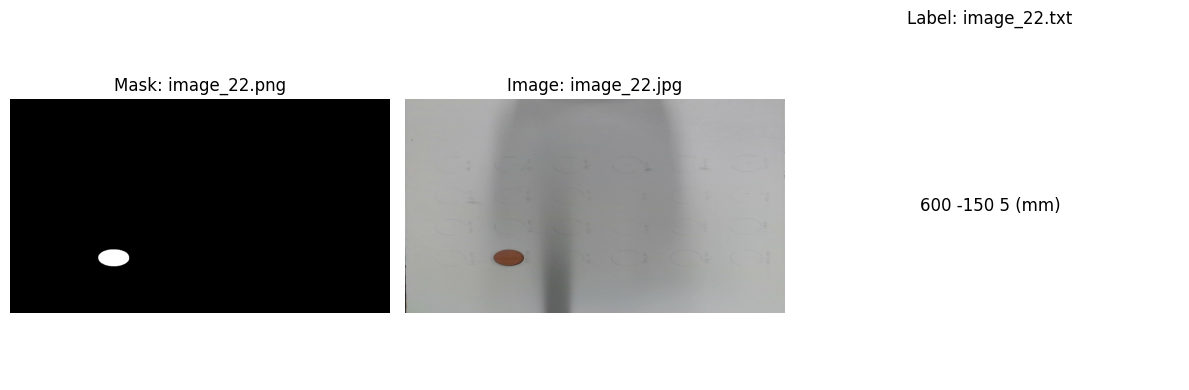

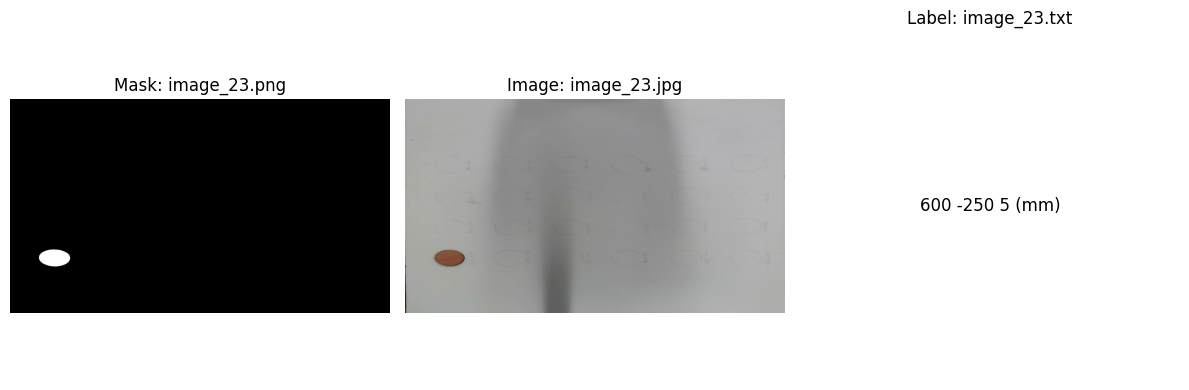

In [14]:
# Ensure that lists have files
if len(mask_files) > 0 and len(img_files) > 0 and len(labels_gt_files) > 0:
    for mask_path, img_path, label_path in zip(mask_files, img_files, labels_gt_files):
        # Load images and labels
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(img_path)
        with open(label_path, 'r') as file:
            label_text = file.read()
            label_text = f'{label_text} (mm)'
        # Convert BGR to RGB for correct visualization in matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the images and labels
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(mask_img, cmap='gray')
        plt.title(f'Mask: {os.path.basename(mask_path)}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(image_rgb)
        plt.title(f'Image: {os.path.basename(img_path)}')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.text(0.5, 0.5, label_text, fontsize=12, ha='center', va='center')
        plt.title(f'Label: {os.path.basename(label_path)}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
else:
    print("Not enough files in the specified directories.")

# 2.- Data Preparation 

This section focuses on a detailed examination of the images and masks within the dataset. Key objectives include:

- **Observing Specific Features**: We identify the specific features of the images and masks, such as dimensions, color depth, and any peculiar patterns or anomalies that might affect the analysis or results.

- **Verifying Binary Masks**: We also ensure that the masks are binary, which means they should contain only two pixel values: one representing the object that the robotic arm has to pick ( with a '1' or '255') and the background (with a '0'). 



## 2.1 Specific Features of The Images and Masks

In [126]:
# Read the images
mask_img = cv2.imread(mask_files[0], cv2.IMREAD_GRAYSCALE)
image = cv2.imread(img_files[0])

# Display information about the images
print("Information on 'mask_img':")
print(f" - Dimensions (Height x Width): {mask_img.shape[0]} x {mask_img.shape[1]}")
print(f" - Number of channels: {'1 (grayscale)' if len(mask_img.shape) == 2 else mask_img.shape[2]}")

print("\nInformation on 'image':")
print(f" - Dimensions (Height x Width): {image.shape[0]} x {image.shape[1]}")
print(f" - Number of channels: {image.shape[2]}")

Information on 'mask_img':
 - Dimensions (Height x Width): 1080 x 1920
 - Number of channels: 1 (grayscale)

Information on 'image':
 - Dimensions (Height x Width): 1080 x 1920
 - Number of channels: 3


## 2.2 Binary Mask Verification

In [122]:
def get_unique_pixel_values(mask_path):
    # Read the image as a grayscale image
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was loaded correctly
    if mask is None:
        raise FileNotFoundError(f"Mask image at {mask_path} could not be loaded.")
    
    # Find unique pixel values
    unique_values = np.unique(mask)
    return unique_values.tolist()

In [123]:
print(get_unique_pixel_values(mask_files[0]))

[0, 255]


**Observation**: In analyzing the mask images, it's clear they are not strictly binary, as they contain pixel values other than the standard 0 for the background and 255 for the foreground. This discovery highlights the need for binarization, which is crucial for consistent data handling and enhancing model performance in segmentation tasks. Binarization, the process of converting all pixel values to 0 or 255 using a set threshold, simplifies computational demands and improves the accuracy of models by ensuring masks are strictly binary. Additionally, the choice of image format affects the integrity of mask data; JPEG, with its lossy compression, may alter necessary pixel values, whereas PNG supports binary images without such alterations, making it preferable for tasks requiring precise binary masks. Thus, the next step is to binarize the masks to maintain the reliability of the segmentation process.


### 2.2.1 Mask Binarization

In [107]:
def binarize_and_replace_masks(mask_files, threshold=127):
    """
    Binarizes all mask images given in the list based on the given threshold,
    removes the original images, and saves the binarized images in place with '_binarized' appended to the file name,
    ensuring the format is PNG to avoid compression issues.
    
    Args:
    mask_files (list): List of paths to the mask files.
    threshold (int): Pixel intensity threshold for binarization.
    """
    for mask_path in mask_files:
        # Read the mask as a grayscale image
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply threshold to binarize the image
        _, binarized_mask = cv2.threshold(mask, threshold, 255, cv2.THRESH_BINARY)
        
        # Remove the original mask file
        os.remove(mask_path)
        
        # Save the binarized mask back to the newly generated path
        cv2.imwrite(mask_path[:-4] + '.png', binarized_mask)

In [108]:
binarize_and_replace_masks(mask_files)

## 2.3 Dataset Splitting

The script ensures equal lengths for mask, image, and label files. It then splits the dataset into training, validation, and test sets with respective proportions of 80% (further split into 80% training and 20% validation) and 20% testing. The total numbers of images for each subset are calculated and displayed.


In [110]:
# Set the proportion of the dataset to be used for testing and validation.
TEST_PROP = 20  # 20% of the dataset for testing
VAL_PROP = 20   # 20% of the remaining dataset after test split for validation

# Ensure that the lists of mask files, image files, and label files have the same length.
if len(mask_files) == len(img_files) == len(labels_gt_files):
    TOTAL = len(mask_files)  # Total number of images

    # Calculate the number of images in the test set.
    TOTAL_TEST = round((TOTAL * TEST_PROP / 100))

    # Calculate the number of images in the validation set.
    # This is 20% of the remaining data after allocating for the test set.
    TOTAL_VAL = round((TOTAL * (1 - (TEST_PROP / 100)) * VAL_PROP / 100))

    # Calculate the number of images in the training set.
    TOTAL_TRAIN = TOTAL - TOTAL_TEST - TOTAL_VAL

    # Print the total number of images and the number of images in each subset.
    print(f"The number of images available: {TOTAL}")
    print(f"Test_images={TOTAL_TEST}")
    print(f"Val_images={TOTAL_VAL}")
    print(f"Train_images={TOTAL_TRAIN}")

The number of images available: 24
Test_images=5
Val_images=4
Train_images=15


This script organizes a dataset by copying image and mask files into designated folders for training, testing, and validation based on predetermined counts. It iterates over the list of mask files, extracting filenames, and places each pair (image and corresponding mask) into the appropriate subdirectory ('imgs' or 'masks') within the main directories ('train', 'test', 'val') based on their designated count. The script uses the `shutil.copyfile` method to handle file copying operations.


In [111]:
# Set the base directory for the dataset and define folder and subfolder names.
BASEDIR = "../dataset/"
FOLDERS = ['test', 'train', 'val']
SUBFOLDERS = ['imgs', 'masks']

# Initialize counters for train, test, and validation.
tr, te, val = 1, 1, 1

# Loop through all mask files.
for i in range(0, len(mask_files)):
    filename = mask_files[i].split('masks\\')[1]  # Extract the filename from the path.

    # Assign files to the training set until the limit is reached.
    if tr <= TOTAL_TRAIN:
        # Copy mask file to the training masks folder.
        dest_path = f"{BASEDIR}/{FOLDERS[1]}/{SUBFOLDERS[1]}/{filename}"
        shutil.copyfile(mask_files[i], dest_path)
        # Copy image file to the training images folder.
        dest_path = f"{BASEDIR}/{FOLDERS[1]}/{SUBFOLDERS[0]}/{filename}"
        shutil.copyfile(img_files[i], dest_path)
        tr += 1  # Increment the train counter.
    else:
        # Assign files to the test set until the limit is reached.
        if te <= TOTAL_TEST:
            # Copy mask file to the test masks folder.
            dest_path = f"{BASEDIR}/{FOLDERS[0]}/{SUBFOLDERS[1]}/{filename}"
            shutil.copyfile(mask_files[i], dest_path)
            # Copy image file to the test images folder.
            dest_path = f"{BASEDIR}/{FOLDERS[0]}/{SUBFOLDERS[0]}/{filename}"
            shutil.copyfile(img_files[i], dest_path)
            te += 1  # Increment the test counter.
        else:
            # Assign files to the validation set until the limit is reached.
            if val <= TOTAL_VAL:
                # Copy mask file to the validation masks folder.
                dest_path = f"{BASEDIR}/{FOLDERS[2]}/{SUBFOLDERS[1]}/{filename}"
                shutil.copyfile(mask_files[i], dest_path)
                # Copy image file to the validation images folder.
                dest_path = f"{BASEDIR}/{FOLDERS[2]}/{SUBFOLDERS[0]}/{filename}"
                shutil.copyfile(img_files[i], dest_path)
                val += 1  # Increment the validation counter.

## 2.4 Dataset Augmentation

Given the limited number of images available in our dataset (24 in total, with only 15 for training), dataset augmentation is a critical strategy to enhance model performance. Augmentation artificially expands the training dataset, which helps prevent overfitting by introducing the model to a broader variety of training scenarios. This practice not only improves generalization but also enhances the model's ability to perform under diverse real-world conditions.

### Applied Augmentations

We have implemented several augmentations, both spatial and photometric, to simulate different environmental conditions:

- **Spatial Transforms:**
  - `HorizontalFlip`, `VerticalFlip`: These operations modify the orientation of images, helping the model learn features independent of orientation.
  - `ShiftScaleRotate`: Adjusts the position, scale, and rotation angle of images, which aids the model in handling images of varying sizes and perspectives.

- **Image-Specific Transforms:**
  - `RandomBrightnessContrast`: Adjusts the brightness and contrast of images, which is vital for dealing with different lighting conditions.
  - `GaussNoise`: Adds noise to images, mimicking the effect of dust and dirt, common in many real-world scenarios.
  - `CoarseDropout`: Creates random holes in images, simulating obstructions in the visual field.
  - `Blur`: Applies blurring to simulate out-of-focus scenarios, helping the model remain effective even when image quality varies.

These augmentations ensure that each image can generate multiple training examples, each presenting the model with slightly different conditions, thereby enriching the training process and enhancing the robustness and accuracy of the model.


In [112]:
#directory routes
TRAINDIR = '../dataset/train/'
VALDIR  = '../dataset/val/'
CORRUPTED_TESTDIR= '../dataset/test-C/original/'
SUBDIR = ['imgs/*','masks/*']

In [113]:
def dataset_augmentation(directory, subdir, aug_factor, apply_image_transforms):
    # Establish directories for image and mask files based on input parameters.
    img_dir = os.path.join(directory, subdir[0])
    mask_dir = os.path.join(directory, subdir[1])

    # Retrieve and sort image and mask files by a numeric part of the filename.
    img_files = sorted(glob.glob(img_dir), key=lambda x: int(x.split('_')[1].split('.')[0]))
    mask_files = sorted(glob.glob(mask_dir), key=lambda x: int(x.split('_')[1].split('.')[0]))

    # Set up spatial transformations that can be applied to both images and masks.
    spatial_transforms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0, rotate_limit=45, p=0.5)
    ])

    # Set up transformations that are specific to images to enhance visual variability.
    image_transforms = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.6),
        A.GaussNoise(var_limit=(10.0, 75.0), p=0.5),
        A.CoarseDropout(max_holes=10, max_height=4, max_width=4, min_holes=1, fill_value=0, p=0.5),
        A.Blur(blur_limit=7, p=0.5)
    ])

    # Process each pair of image and mask files.
    for img_path, mask_path in zip(img_files, mask_files):
        # Load the image and its corresponding mask.
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Create augmented versions of each image, up to the specified augmentation factor.
        for i in range(aug_factor):
            # Apply spatial transformations to both the image and mask.
            augmented = spatial_transforms(image=img, mask=mask)
            aug_img = augmented['image']
            aug_mask = augmented['mask']

            # Apply additional transformations only to the image if the boolean is True.
            if apply_image_transforms:
                aug_img = image_transforms(image=aug_img)['image']

            # Construct file names and save the augmented images and masks to disk.
            aug_img_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_aug_{i}.jpg"
            aug_mask_name = f"{os.path.splitext(os.path.basename(mask_path))[0]}_aug_{i}.png"
            cv2.imwrite(f'../{os.path.join(img_path.strip(os.path.basename(img_path)), aug_img_name)}', aug_img)
            cv2.imwrite(f'../{os.path.join(mask_path.strip(os.path.basename(mask_path)), aug_mask_name)}', aug_mask)
            
#Training Augmentation
dataset_augmentation(TRAINDIR, SUBDIR, aug_factor=50, apply_image_transforms=True)
#Validation_Augmentation
dataset_augmentation(VALDIR, SUBDIR, aug_factor=50, apply_image_transforms=True)
#Test augmentation
dataset_augmentation(CORRUPTED_TESTDIR, SUBDIR, aug_factor=10, apply_image_transforms=False)


### 2.4.1  Building the test set to evaluate Model Robustness with Imagenet-C Corruptions

Applying Imagenet-C corruptions to evaluate the robustness of a model is essential to ensure that the model can maintain acceptable performance under adverse conditions. In real industrial environments, images can suffer various distortions due to factors such as hardware quality, environmental conditions, and image handling. Therefore, evaluating a model with these types of corruptions helps ensure that the model not only performs well under ideal conditions but is also resilient to a variety of unforeseen situations.

Below we define the corruption functions taken from the Imagenet-C repository. Some of the functions have been modified to accept inputs of any size instead of a 224x224 image.


#### Types of Corruptions

- **Gaussian Noise**: Adding Gaussian noise simulates random interference that can arise from camera sensors, especially in low-light conditions. Evaluating robustness against this type of noise ensures that the model can handle images taken in noisy and low-quality settings.

- **Shot Noise**: This type of noise mimics variations in photon intensity captured by the camera sensor, common in low-light or low-quality camera images. Testing the model with shot noise verifies its performance in poor lighting conditions.

- **Impulse Noise**: Also known as salt-and-pepper noise, it simulates dead or defective pixels in a camera sensor. The model's ability to handle this noise is crucial in scenarios where the capture hardware is not perfect.

- **Defocus Blur**: This type of blur simulates out-of-focus images due to camera or subject movement. Robustness against defocus blur ensures that the model can recognize objects even when images are not perfectly focused.

- **Glass Blur**: Simulates distortion caused by capturing images through transparent but irregular surfaces, such as dirty or imperfect glass. Evaluating against this corruption ensures the model can handle images captured in industrial environments where glass surfaces may not be clean.

- **Motion Blur**: Imitates blur that occurs due to camera or object movement during image capture. Robustness to this type of distortion is important for applications involving moving objects, such as vehicles or machinery in operation.

- **Fog**: Simulates loss of contrast caused by fog or smoke, common in certain industrial environments. Ensuring the model can function in these conditions is crucial for outdoor applications or factories with emissions.

- **Brightness and Contrast**: Adjusting brightness and contrast simulates variations in lighting conditions and image quality. Evaluating robustness against these factors ensures the model can handle images taken in different lighting conditions and exposure levels.

- **Elastic Transform**: This transformation simulates geometric distortions that can occur due to physical manipulation of objects or capture errors. Evaluating against these distortions ensures the model can recognize objects even if they have been deformed.

- **Speckle Noise**: This noise mimics granular variations present in images obtained by low-quality sensors or in low-light conditions. Robustness to this type of noise is essential for applications that rely on the integrity of data captured by sensors.

- **Gaussian Blur**: Simulates blur caused by the optical limitations of the camera lens. Evaluating robustness against this type of blur is important for applications requiring high precision in detail recognition.

- **Spatter**: Simulates interference from liquid or solid particles on the camera lens, which can occur in industrial environments with the presence of liquids or dust in the air. Evaluating the model against this corruption ensures it can handle images captured in dirty environments.

- **Saturate**: Adjusting the saturation of the image simulates color variations that can occur due to lighting or sensor quality. Robustness against these variations is important for applications that depend on color accuracy for object identification.

Each of these corruptions helps evaluate how well the model can maintain its performance in adverse situations, thus ensuring its applicability in various industrial scenarios where conditions may not always be ideal.


In [6]:
def glass_blur(x, severity=1):
    # sigma, max_delta, iterations
    params = [(0.7, 1, 2), (0.9, 2, 1), (1, 2, 3), (1.1, 3, 2), (1.5, 4, 2)][severity - 1]
    sigma, max_delta, iterations = params
    # Apply initial Gaussian blur
    x_blurred = gaussian_filter(x, sigma=sigma, mode='reflect')
    # Get dimensions of the image
    height, width = x.shape[:2]
    # Locally shuffle pixels
    for i in range(iterations):
        for h in range(max_delta, height - max_delta):
            for w in range(max_delta, width - max_delta):
                dx, dy = random.randint(-max_delta, max_delta), random.randint(-max_delta, max_delta)
                h_prime, w_prime = h + dy, w + dx

                # Ensuring target indices are within bounds
                if 0 <= h_prime < height and 0 <= w_prime < width:
                    # Swap pixels
                    x_blurred[h, w], x_blurred[h_prime, w_prime] = x_blurred[h_prime, w_prime], x_blurred[h, w]

    # Apply Gaussian blur again to smooth out the effects
    x_blurred = gaussian_filter(x_blurred, sigma=sigma, mode='reflect')
    # Ensure pixel values are within the proper range
    return np.clip(x_blurred, 0, 255)

def motion_blur(image, severity=1):
    # Define parameters for the blur: radius, and angle range
    params = [(10, 3), (15, 5), (15, 8), (15, 12), (20, 15)][severity - 1]
    radius, max_angle = params
    # Convert to PIL image for applying the filter
    pil_img = Image.fromarray(image.astype(np.uint8))
    # Randomly choose an angle for the motion blur
    angle = random.uniform(-max_angle, max_angle)
    # Create a motion blur filter
    blur_filter = ImageFilter.GaussianBlur(radius=radius)
    # Apply the filter
    blurred_image = pil_img.filter(blur_filter)
    # Convert back to numpy array
    return np.array(blurred_image)

def gaussian_noise(x, severity=1):
    c = [.08, .12, 0.18, 0.26, 0.38][severity - 1]
    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255

def shot_noise(x, severity=1):
    c = [60, 25, 12, 5, 3][severity - 1]
    x = np.array(x) / 255.
    return np.clip(np.random.poisson(x * c) / c, 0, 1) * 255

def impulse_noise(x, severity=1):
    c = [.03, .06, .09, 0.17, 0.27][severity - 1]
    x = sk_util.random_noise(np.array(x) / 255., mode='s&p', amount=c)
    return np.clip(x, 0, 1) * 255

def speckle_noise(x, severity=1):
    c = [.15, .2, 0.35, 0.45, 0.6][severity - 1]
    x = np.array(x) / 255.
    return np.clip(x + x * np.random.normal(size=x.shape, scale=c), 0, 1) * 255

def gaussian_blur(x, severity=1):
    c = [1, 2, 3, 4, 6][severity - 1]
    x = np.array(x) / 255.
    x = gaussian_filter(x, sigma=c, mode='mirror')
    return np.clip(x, 0, 1) * 255

def defocus_blur(x, severity=1):
    c = [(3, 0.1), (4, 0.5), (6, 0.5), (8, 0.5), (10, 0.5)][severity - 1]
    x = np.array(x) / 255.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*c[0]+1, 2*c[0]+1))
    channels = []
    for d in range(3):
        channels.append(convolve(x[:, :, d], kernel))
    channels = np.array(channels).transpose((1, 2, 0))  # Reordering the channels to the last dimension
    return np.clip(channels, 0, 1) * 255

def plasma_fractal(shape, wibbledecay=2):
    # Placeholder for a more sophisticated fractal generation
    return np.random.rand(*shape)

def fog(x, severity=1):
    c = [(1.5, 2), (2, 2), (2.5, 1.7), (2.5, 1.5), (3, 1.4)][severity - 1]

    x = np.array(x) / 255.
    max_val = x.max()
    # Adjust the fractal generation to the shape of the image
    plasma = plasma_fractal(x.shape[:2], wibbledecay=c[1])
    plasma = np.expand_dims(plasma, axis=-1)  # Extend plasma to 3D if needed
    
    x += c[0] * plasma
    return np.clip(x * max_val / (max_val + c[0]), 0, 1) * 255

def spatter(x, severity=1):
    c = [(0.65, 0.3, 4, 0.69, 0.6, 0),
         (0.65, 0.3, 3, 0.68, 0.6, 0),
         (0.65, 0.3, 2, 0.68, 0.5, 0),
         (0.65, 0.3, 1, 0.65, 1.5, 1),
         (0.67, 0.4, 1, 0.65, 1.5, 1)][severity - 1]
    x = np.array(x, dtype=np.float32) / 255.

    liquid_layer = np.random.normal(size=x.shape[:2], loc=c[0], scale=c[1])

    liquid_layer = gaussian_filter(liquid_layer, sigma=c[2])
    liquid_layer[liquid_layer < c[3]] = 0
    if c[5] == 0:
        liquid_layer = (liquid_layer * 255).astype(np.uint8)
        dist = 255 - cv2.Canny(liquid_layer, 50, 150)
        dist = cv2.distanceTransform(dist, cv2.DIST_L2, 5)
        _, dist = cv2.threshold(dist, 20, 20, cv2.THRESH_TRUNC)
        dist = cv2.blur(dist, (3, 3)).astype(np.uint8)
        dist = cv2.equalizeHist(dist)
        ker = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
        dist = cv2.filter2D(dist, cv2.CV_8U, ker)
        dist = cv2.blur(dist, (3, 3)).astype(np.float32)

        m = cv2.cvtColor(liquid_layer * dist, cv2.COLOR_GRAY2BGRA)
        m /= np.max(m, axis=(0, 1))
        m *= c[4]

        # water is pale turquoise
        color = np.concatenate((175 / 255. * np.ones_like(m[..., :1]),
                                238 / 255. * np.ones_like(m[..., :1]),
                                238 / 255. * np.ones_like(m[..., :1])), axis=2)

        color = cv2.cvtColor(color, cv2.COLOR_BGR2BGRA)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2BGRA)

        return cv2.cvtColor(np.clip(x + m * color, 0, 1), cv2.COLOR_BGRA2BGR) * 255
    else:
        m = np.where(liquid_layer > c[3], 1, 0)
        m = gaussian_filter(m.astype(np.float32), sigma=c[4])
        m[m < 0.8] = 0

        # mud brown
        color = np.concatenate((63 / 255. * np.ones_like(x[..., :1]),
                                42 / 255. * np.ones_like(x[..., :1]),
                                20 / 255. * np.ones_like(x[..., :1])), axis=2)

        color *= m[..., np.newaxis]
        x *= (1 - m[..., np.newaxis])

        return np.clip(x + color, 0, 1) * 255
    
def contrast(x, severity=1):
    c = [0.4, .3, .2, .1, .05][severity - 1]
    x = np.array(x) / 255.
    means = np.mean(x, axis=(0, 1), keepdims=True)
    return np.clip((x - means) * c + means, 0, 1) * 255    

def brightness(x, severity=1):
    c = [.1, .2, .3, .4, .5][severity - 1]
    x = np.array(x) / 255.
    x = sk.rgb2hsv(x)
    x[:, :, 2] = np.clip(x[:, :, 2] + c, 0, 1)
    x = sk.hsv2rgb(x)
    return np.clip(x, 0, 1) * 255

def saturate(x, severity=1):
    c = [(0.3, 0), (0.1, 0), (2, 0), (5, 0.1), (20, 0.2)][severity - 1]
    x = np.array(x) / 255.
    x = sk.rgb2hsv(x)
    x[:, :, 1] = np.clip(x[:, :, 1] * c[0] + c[1], 0, 1)
    x = sk.hsv2rgb(x)
    return np.clip(x, 0, 1) * 255

#def pixelate(x, severity=1):
    c = [0.6, 0.5, 0.4, 0.3, 0.25][severity - 1]
    original_size = x.size
    x = x.resize((int(original_size[0] * c), int(original_size[1] * c)), Image.BOX)
    x = x.resize(original_size, Image.BOX)
    return x

def elastic_transform(image, severity=1):
    c = [(244 * 2, 244 * 0.7, 244 * 0.1),   # 244 should have been 224, but ultimately nothing is incorrect
         (244 * 2, 244 * 0.08, 244 * 0.2),
         (244 * 0.05, 244 * 0.01, 244 * 0.02),
         (244 * 0.07, 244 * 0.01, 244 * 0.02),
         (244 * 0.12, 244 * 0.01, 244 * 0.02)][severity - 1]

    image = np.array(image, dtype=np.float32) / 255.
    shape = image.shape
    shape_size = shape[:2]

    # random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size,
                       [center_square[0] + square_size, center_square[1] - square_size],
                       center_square - square_size])
    pts2 = pts1 + np.random.uniform(-c[2], c[2], size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = (gaussian_filter(np.random.uniform(-1, 1, size=shape[:2]),
                   c[1], mode='reflect', truncate=3) * c[0]).astype(np.float32)
    dy = (gaussian_filter(np.random.uniform(-1, 1, size=shape[:2]),
                   c[1], mode='reflect', truncate=3) * c[0]).astype(np.float32)
    dx, dy = dx[..., np.newaxis], dy[..., np.newaxis]

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))
    return np.clip(map_coordinates(image, indices, order=1, mode='reflect').reshape(shape), 0, 1) * 255

corruption_function_map = {
    'gaussian_noise': gaussian_noise,
    'shot_noise': shot_noise,
    'impulse_noise': impulse_noise,
    'defocus_blur': defocus_blur,
    'glass_blur': glass_blur,
    'motion_blur': motion_blur,
    'fog': fog,
    'brightness' :brightness,
    'contrast':contrast,
    'elastic_transform':elastic_transform,
    'speckle_noise': speckle_noise,
    'gaussian_blur':gaussian_blur,
    'spatter':spatter,
    'saturate':saturate
   
}

In this code snippet, we will create the folders for the corrupted test with the various types of corruptions. We start by generating a list with all the corruptions, and we will create a new folder for each corruption. The folder names will be c{i} where i is the index of the corruption in the list. Inside this folder, there will be a series of subfolders named s{i} where i will be the index of the severity with which we apply the corruption. In this subfolder, there will be two more subfolders named 'imgs' and 'masks'.


In [8]:
# Path to the directory containing the original images and masks
CORRUPTED_TESTDIR = '../data/images-rgb-C/original'
SUBDIR = ['imgs/*', 'masks/*']

def create_directories(base_path, corruption_list):
    """Create directory structure for storing corrupted images and masks at the same level as the original directory."""
    for i, corruption in enumerate(corruption_list):
        for severity in range(1, 6):
            # Path for corruption type and severity, created at the same level as the original directory
            path = os.path.join(base_path, "..", f"c{i}", f"s{severity}")
            # Create directories for images and masks
            os.makedirs(os.path.join(path, "imgs"), exist_ok=True)
            os.makedirs(os.path.join(path, "masks"), exist_ok=True)

def apply_corruption(image, corruption_type, severity):
    """Apply specified corruption to the image based on type and severity."""
    # Converting PIL image to numpy array for processing
    img_array = np.array(image)
    # Call the appropriate corruption function
    if corruption_type in corruption_function_map:
        corrupted_array = corruption_function_map[corruption_type](img_array, severity)
        # Convert back to PIL image
        return Image.fromarray(corrupted_array.astype(np.uint8))
    return image  # Return original if no corruption function found

def process_images_and_masks(directory, subdir, corruption_function_map):
    corruption_list = list(corruption_function_map.keys())
    corruption_list = ['speckle_noise', 'gaussian_blur',  ]
    """Process images by applying corruptions and copying masks to the appropriate directories, storing them at the same level as the original directory."""
    img_dir = os.path.join(directory, subdir[0])
    mask_dir = os.path.join(directory, subdir[1])

    img_files = sorted(glob.glob(img_dir), key=lambda x: int(x.split('_')[1].split('.')[0]))
    mask_files = sorted(glob.glob(mask_dir), key=lambda x: int(x.split('_')[1].split('.')[0]))

    # Create directories
    create_directories(directory, corruption_list)
    corruption_list = list(corruption_function_map.keys())
    lista = [10]
    for i, corruption in enumerate(corruption_list):
        print(i,corruption)
        if i in lista: 
            for severity in range(1, 6):
                for img_path, mask_path in zip(img_files, mask_files):
                    # Load image
                    image = Image.open(img_path)
                    mask = Image.open(mask_path)
                
                    # Apply corruption
                    corrupted_image = apply_corruption(image, corruption, severity)
                
                    # Build paths for corrupted image and mask, stored at the same level as the original
                    img_output_path = os.path.join(directory, "..", f"c{i}", f"s{severity}", "imgs", os.path.basename(img_path))
                    mask_output_path = os.path.join(directory, "..", f"c{i}", f"s{severity}", "masks", os.path.basename(mask_path))
                
                    # Save corrupted image
                    corrupted_image.save(img_output_path)
                
                    # Copy mask
                    mask.save(mask_output_path)
        else: 
            continue
                
process_images_and_masks(CORRUPTED_TESTDIR, SUBDIR, corruption_function_map)

0 gaussian_noise
1 shot_noise
2 impulse_noise
3 defocus_blur
4 glass_blur
5 motion_blur
6 fog
7 brightness
8 contrast
9 elastic_transform
10 speckle_noise
11 gaussian_blur
12 spatter
13 saturate
